# 2.1.1 — Steel Energy Refactored V1 


# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, List, Tuple, Optional

#DATA_PATH_MOD = "../../data/raw/steel_energy_modified.csv"
#DATA_PATH_ORIG = "../../data/raw/steel_energy_original.csv"

NUMERIC_COLUMNS = [
    'usage_kwh','lagging_current_reactive.power_kvarh',
    'leading_current_reactive_power_kvarh','co2(tco2)',
    'lagging_current_power_factor','leading_current_power_factor','nsm'
]
TEXT_COLS = ['weekstatus','day_of_week','load_type']
TARGET_COL = 'usage_kwh'

np.random.seed(42)

# Loading and exploring the data

In [2]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    return data

def explore_data(data):
    print(data.head().T)
    print(data.describe())
    print(data.info())

# Cleaning and correct formats

In [3]:
def clean_and_correct_formats(
    df: pd.DataFrame,
    numeric_cols: List[str] = None,
    text_cols: List[str] = None,
    date_col: str = "date",
    index_to_check: int = 32905,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Limpia columnas, corrige tipos (fecha, numéricas y texto), identifica NaNs,
    y muestra verificaciones al final (sample(20), info() y la fila por índice).

    Returns
    -------
    df : DataFrame limpio
    row_check : DataFrame con la fila cuyo índice == index_to_check
    """
    # --- parámetros por defecto según tu dataset ---
    if numeric_cols is None:
        numeric_cols = [
            "usage_kwh",
            "lagging_current_reactive.power_kvarh",
            "leading_current_reactive_power_kvarh",
            "co2(tco2)",
            "lagging_current_power_factor",
            "leading_current_power_factor",
            "nsm",
        ]
    if text_cols is None:
        text_cols = ["weekstatus", "day_of_week", "load_type"]

    # --- 1) Limpieza general ---
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    df = df.drop_duplicates().reset_index(drop=True)

    # --- 2) Corrección de fecha ---
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # --- 3) Corrección de columnas numéricas ---
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # --- 4) Corrección de columnas de texto ---
    for col in text_cols:
        if col in df.columns:
            # normaliza espacios, minúsculas y luego capitaliza
            df[col] = (
                df[col]
                .astype(str)
                .str.strip()
                .str.replace(r"\s+", " ", regex=True)
                .str.lower()
                .replace(
                    # valores que representan "vacío" → NaN
                    {"nan": np.nan, "none": np.nan, "na": np.nan, "": np.nan}
                )
            )
            # capitalizar solo valores no nulos
            df.loc[df[col].notna(), col] = df.loc[df[col].notna(), col].str.capitalize()

    # --- 5) Identificar NaNs (incluye conteo por columna) ---
    # (reemplazos ya hechos arriba; ahora solo contamos)
    print("\nConteo de valores NaN por columna:")
    print(df.isna().sum())

    # --- 6) Verificaciones finales ---
    print("\nMuestra aleatoria de 20 filas (df.sample(20)):")
    try:
        display(df.sample(20))  # en notebook mostrará tabla; en script, se imprime
    except Exception:
        print(df.sample(20))

    print("\nInformación del DataFrame (df.info()):")
    df.info()

    print(f"\n# Fila con índice == {index_to_check}")
    row_check = df[df.index == index_to_check]
    try:
        display(row_check)
    except Exception:
        print(row_check)

    return df, row_check

#uso de la funcion: 
# df_clean, row_32905 = clean_and_correct_formats(df)


# Visualizing the data

In [4]:
# =========================
# Visualización y análisis
# =========================


# --------- Utilidades ---------
def _resolve_column_name(df: pd.DataFrame, candidates: Iterable[str]) -> str:
    """
    Devuelve el nombre de columna existente en df que coincida (ignorando mayúsculas,
    guiones bajos, espacios y puntos) con alguno de los 'candidates'.
    Lanza KeyError si no encuentra.
    """
    def norm(s: str) -> str:
        return (
            str(s)
            .lower()
            .replace(" ", "")
            .replace("_", "")
            .replace(".", "")
        )

    normalized_cols = {norm(c): c for c in df.columns}
    for cand in candidates:
        key = norm(cand)
        if key in normalized_cols:
            return normalized_cols[key]
    raise KeyError(f"Ninguna coincidencia para {list(candidates)} en columnas de df.")


def describe_with_percentiles(
    df: pd.DataFrame,
    column: str,
    percentiles: Iterable[float] = (0.05, 0.25, 0.5, 0.75, 0.99)
) -> pd.Series:
    """Atajo para describe() con percentiles personalizados."""
    col = _resolve_column_name(df, [column])
    desc = df[col].describe(percentiles=list(percentiles))
    print(desc)
    return desc


def filter_by_threshold(
    df: pd.DataFrame,
    column: str,
    upper: Optional[float] = None,
    lower: Optional[float] = None,
    inclusive: bool = True
) -> pd.DataFrame:
    """
    Filtra un DataFrame por límites inferior/superior. Si upper/lower son None, no se aplican.
    """
    col = _resolve_column_name(df, [column])
    mask = pd.Series(True, index=df.index)
    if lower is not None:
        mask &= df[col] >= lower if inclusive else df[col] > lower
    if upper is not None:
        mask &= df[col] <= upper if inclusive else df[col] < upper
    return df[mask].copy()


# --------- Univariado (boxplots) ---------
def plot_box_with_percentile(
    df: pd.DataFrame,
    column: str,
    percentile: float = 0.99,
    title_prefix: str = "Distribución",
    log_y: bool = False
) -> float:
    """
    Boxplot univariado con línea horizontal en el percentil indicado.
    Retorna el valor del percentil.
    """
    col = _resolve_column_name(df, [column])
    p_val = float(df[col].quantile(percentile))

    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col].dropna(), vert=True, patch_artist=True)
    if log_y:
        plt.yscale("log")
    plt.axhline(y=p_val, color="red", linestyle="--", label=f'Percentil {int(percentile*100)} ({p_val:.3g})')
    plt.title(f'{title_prefix} de {col}')
    plt.ylabel(col + (" (escala log)" if log_y else ""))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

    return p_val


def analyze_univariate_box(
    df: pd.DataFrame,
    column: str,
    cap_value: Optional[float] = None,
    percentile: float = 0.99,
    log_y: bool = False
) -> Tuple[pd.DataFrame, float]:
    """
    1) Describe + boxplot con línea en percentil.
    2) Filtra por cap (si cap_value es None usa el percentil).
    3) Segundo boxplot del DataFrame filtrado + df_filtrado.info()

    Retorna (df_filtrado, valor_percentil)
    """
    col = _resolve_column_name(df, [column])

    print(f"\n--- Describe de {col} (antes de filtrar) ---")
    describe_with_percentiles(df, col)

    p_val = plot_box_with_percentile(df, col, percentile=percentile, title_prefix="Distribución", log_y=log_y)
    print(f"Percentil {int(percentile*100)} de {col}: {p_val:.6g}")

    cut = p_val if cap_value is None else float(cap_value)
    df_filtered = filter_by_threshold(df, col, upper=cut, inclusive=True)

    print(f"\n--- Describe de {col} (después de filtrar <= {cut:.6g}) ---")
    describe_with_percentiles(df_filtered, col)

    # Segundo boxplot sobre el filtrado
    _ = plot_box_with_percentile(
        df_filtered, col, percentile=percentile,
        title_prefix="Distribución (filtrado)", log_y=log_y
    )
    print("\nInformación del DataFrame filtrado:")
    df_filtered.info()

    return df_filtered, p_val


# --------- Casos específicos que mencionaste ---------
def analyze_usage_kwh(df: pd.DataFrame, cap_value: Optional[float] = 157.0) -> pd.DataFrame:
    """
    Reproduce tu flujo para 'usage_kwh':
    - describe + boxplot con p99
    - filtra por <= cap_value (por defecto 157, o None para usar p99)
    - nuevo describe + boxplot + info()
    Retorna df_filtrado.
    """
    df_filtrado, p99 = analyze_univariate_box(
        df=df, column=TARGET_COL, cap_value=cap_value, percentile=0.99, log_y=False
    )
    print(f"\nValor p99 observado en {TARGET_COL}: {p99:.6g}")
    return df_filtrado


def analyze_lagging_reactive_kvarh(df: pd.DataFrame) -> None:
    """
    Maneja nombres alternos:
    - 'Lagging_Current_Reactive.Power_kVarh' (variación mayús/minús)
    - 'lagging_current_reactive.power_kvarh'
    """
    col = _resolve_column_name(
        df, ["Lagging_Current_Reactive.Power_kVarh", "lagging_current_reactive.power_kvarh"]
    )
    print(f"\n--- Describe para {col} ---")
    describe_with_percentiles(df, col)
    _ = plot_box_with_percentile(df, col, percentile=0.99, title_prefix="Distribución", log_y=False)


def analyze_co2_tco2(df: pd.DataFrame, hard_cap: float = 0.070) -> pd.DataFrame:
    """
    Describe + boxplot + p99 y filtra df por co2(tco2) <= hard_cap (0.070 por tu ejemplo).
    Retorna el DataFrame filtrado.
    """
    col = _resolve_column_name(df, ["co2(tco2)"])
    print(f"\n--- Describe para {col} ---")
    describe_with_percentiles(df, col, percentiles=(0.05, 0.25, 0.5, 0.75, 0.96, 0.99, 0.995))

    p99 = plot_box_with_percentile(df, col, percentile=0.99, title_prefix="Distribución", log_y=False)
    print(f"Percentil 99 de {col}: {p99:.6g}")

    df_cap = filter_by_threshold(df, col, upper=hard_cap, inclusive=True)
    print(f"\nFiltrado: {col} <= {hard_cap}")
    df_cap.info()

    # Opcional: quick sanity
    _ = plot_box_with_percentile(df_cap, col, percentile=0.99, title_prefix="Distribución (filtrado)", log_y=False)
    return df_cap


# --------- Multivariado ---------
def plot_correlation_matrix(
    df: pd.DataFrame,
    include_dtypes: Iterable[str] = ("float64", "int64"),
    title: str = "Matriz de Correlación entre Variables Numéricas"
) -> None:
    """
    Calcula corr() sobre columnas numéricas (según include_dtypes) y muestra un heatmap.
    """
    num_df = df.select_dtypes(include=list(include_dtypes))
    plt.figure(figsize=(12, 8))
    sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(title)
    plt.show()


# --------- Atajos para df y df_objetivo ---------
def plot_box_p99_for(
    df: pd.DataFrame, column: str, percentile: float = 0.99, title_suffix: str = ""
) -> float:
    """Atajo genérico para dibujar boxplot con línea en pXX y devolver el valor del percentil."""
    return plot_box_with_percentile(
        df=df, column=column, percentile=percentile,
        title_prefix=f"Distribución{(' ' + title_suffix) if title_suffix else ''}",
        log_y=False
    )


def corr_matrix_for(df: pd.DataFrame, title_suffix: str = "") -> None:
    """Atajo genérico para matriz de correlación."""
    plot_correlation_matrix(
        df=df,
        title=f"Matriz de Correlación entre Variables Numéricas{(' - ' + title_suffix) if title_suffix else ''}"
    )

#df_filtrado = analyze_usage_kwh(df, cap_value=157.0)   # o cap_value=None para cortar en p99
#analyze_lagging_reactive_kvarh(df)
#df = analyze_co2_tco2(df, hard_cap=0.070)
#corr_matrix_for(df, title_suffix="DF completo")
# Si tienes df_objetivo:
#corr_matrix_for(df_objetivo, title_suffix="DF objetivo")
#p99 = plot_box_p99_for(df_objetivo, column=TARGET_COL, title_suffix="(df_objetivo)")


📂 Cargando dataset MODIFICADO desde: ../../data/raw/steel_energy_modified.csv
✅ Dataset modificado cargado con 35740 filas y 12 columnas

📂 Cargando dataset OBJETIVO desde: ../../data/raw/steel_energy_original.csv
✅ Dataset objetivo cargado con 35040 filas y 11 columnas

🧹 LIMPIEZA Y CORRECCIÓN DEL DATASET MODIFICADO

Conteo de valores NaN por columna:
date                                    22463
usage_kwh                                 516
lagging_current_reactive.power_kvarh      530
leading_current_reactive_power_kvarh      554
co2(tco2)                                 510
lagging_current_power_factor              572
leading_current_power_factor              526
nsm                                       555
weekstatus                                362
day_of_week                               327
load_type                                 328
mixed_type_col                           3444
dtype: int64

Muestra aleatoria de 20 filas (df.sample(20)):


,date,usage_kwh,lagging_current_reactive.power_kvarh,leading_current_reactive_power_kvarh,co2(tco2),lagging_current_power_factor,leading_current_power_factor,nsm,weekstatus,day_of_week,load_type,mixed_type_col
6361,2018-08-03 06:30:00,3.74,3.42,0.00,0.00,73.80,100.00,23400.0,Weekday,Thursday,Light_load,bad
14426,NaT,2.88,5.33,0.00,0.00,47.54,100.00,24300.0,Weekday,Thursday,Light_load,unknown
1771,NaT,118.69,45.83,0.00,0.05,93.29,100.00,39600.0,Weekday,Friday,Maximum_load,773
5886,NaT,3.85,3.89,915.00,0.00,70.34,100.00,27900.0,Weekend,Saturday,Light_load,399
28107,NaT,4.93,0.00,18.07,0.00,100.00,26.32,68400.0,Weekend,Saturday,Medium_load,bad
8426,NaT,47.59,21.56,0.00,0.02,91.09,100.00,67500.0,Weekday,Thursday,Medium_load,unknown
28280,NaT,99.97,57.20,0.00,NaN,86.80,100.00,51300.0,Weekday,Monday,Maximum_load,NaN
10888,NaT,48.35,9.04,0.00,0.02,98.30,100.00,36900.0,Weekday,Tuesday,Maximum_load,207
6187,2018-06-03 11:00:00,57.53,20.09,0.00,0.03,94.41,100.00,39600.0,Weekday,Tuesday,Maximum_load,137
3633,2018-07-02 20:30:00,36.61,0.32,5.22,0.02,100.00,99.00,73800.0,Weekday,Wednesday,Medium_load,NaN



Información del DataFrame (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35735 entries, 0 to 35734
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  13272 non-null  datetime64[ns]
 1   usage_kwh                             35219 non-null  float64       
 2   lagging_current_reactive.power_kvarh  35205 non-null  float64       
 3   leading_current_reactive_power_kvarh  35181 non-null  float64       
 4   co2(tco2)                             35225 non-null  float64       
 5   lagging_current_power_factor          35163 non-null  float64       
 6   leading_current_power_factor          35209 non-null  float64       
 7   nsm                                   35180 non-null  float64       
 8   weekstatus                            35373 non-null  object        
 9   day_of_week                     

,date,usage_kwh,lagging_current_reactive.power_kvarh,leading_current_reactive_power_kvarh,co2(tco2),lagging_current_power_factor,leading_current_power_factor,nsm,weekstatus,day_of_week,load_type,mixed_type_col
32905,2018-09-12 18:30:00,3.31,0.0,9.25,0.0,100.0,33.69,66600.0,Weekend,Sunday,Light_load,124



--- Describe de usage_kwh (antes de filtrar) ---
count    35219.000000
mean        39.400554
std        276.535424
min          0.000000
5%           2.740000
25%          3.240000
50%          4.610000
75%         52.060000
99%        143.677400
max      34899.480000
Name: usage_kwh, dtype: float64


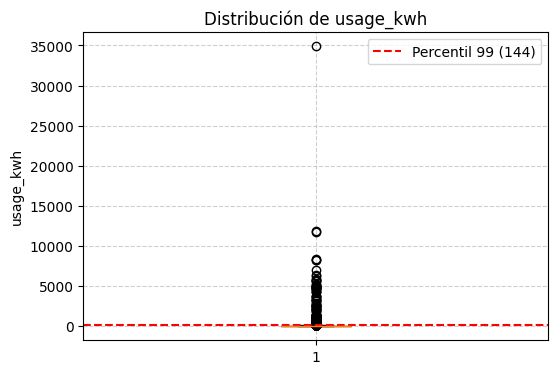

Percentil 99 de usage_kwh: 143.677

--- Describe de usage_kwh (después de filtrar <= 157) ---
count    34896.000000
mean        27.371668
std         33.466695
min          0.000000
5%           2.740000
25%          3.200000
50%          4.570000
75%         51.160000
99%        123.082000
max        156.240000
Name: usage_kwh, dtype: float64


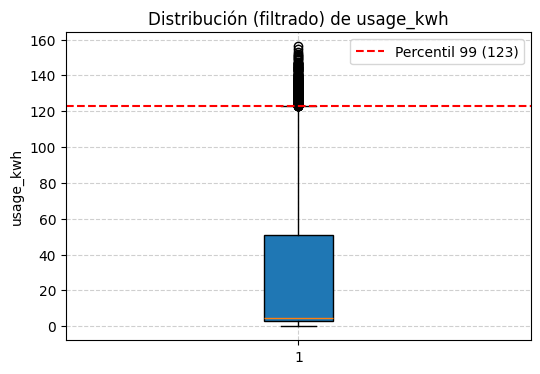


Información del DataFrame filtrado:
<class 'pandas.core.frame.DataFrame'>
Index: 34896 entries, 0 to 35734
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  12962 non-null  datetime64[ns]
 1   usage_kwh                             34896 non-null  float64       
 2   lagging_current_reactive.power_kvarh  34377 non-null  float64       
 3   leading_current_reactive_power_kvarh  34364 non-null  float64       
 4   co2(tco2)                             34394 non-null  float64       
 5   lagging_current_power_factor          34340 non-null  float64       
 6   leading_current_power_factor          34386 non-null  float64       
 7   nsm                                   34352 non-null  float64       
 8   weekstatus                            34540 non-null  object        
 9   day_of_week                           34

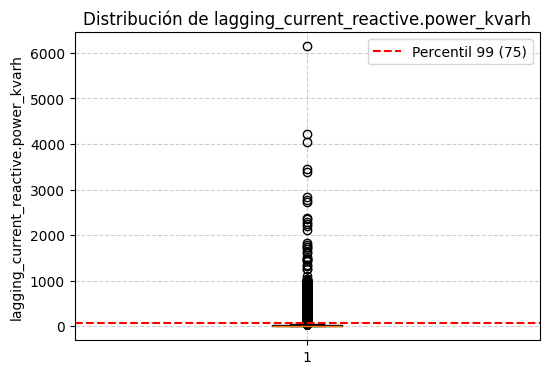


--- Describe para co2(tco2) ---
count    34394.000000
mean         2.618909
std         41.602429
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.020000
96%          0.050000
99%          0.060000
99.5%        2.911050
max       1364.040000
Name: co2(tco2), dtype: float64


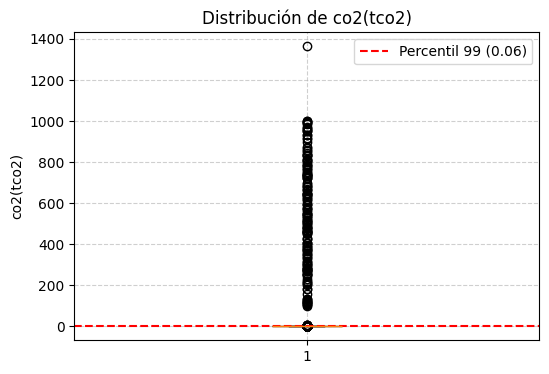

Percentil 99 de co2(tco2): 0.06

Filtrado: co2(tco2) <= 0.07
<class 'pandas.core.frame.DataFrame'>
Index: 34161 entries, 1 to 35734
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  12702 non-null  datetime64[ns]
 1   usage_kwh                             34161 non-null  float64       
 2   lagging_current_reactive.power_kvarh  33655 non-null  float64       
 3   leading_current_reactive_power_kvarh  33643 non-null  float64       
 4   co2(tco2)                             34161 non-null  float64       
 5   lagging_current_power_factor          33614 non-null  float64       
 6   leading_current_power_factor          33657 non-null  float64       
 7   nsm                                   33630 non-null  float64       
 8   weekstatus                            33808 non-null  object        
 9   day_of_week     

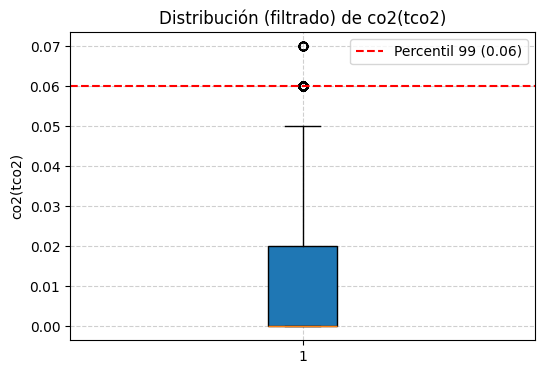

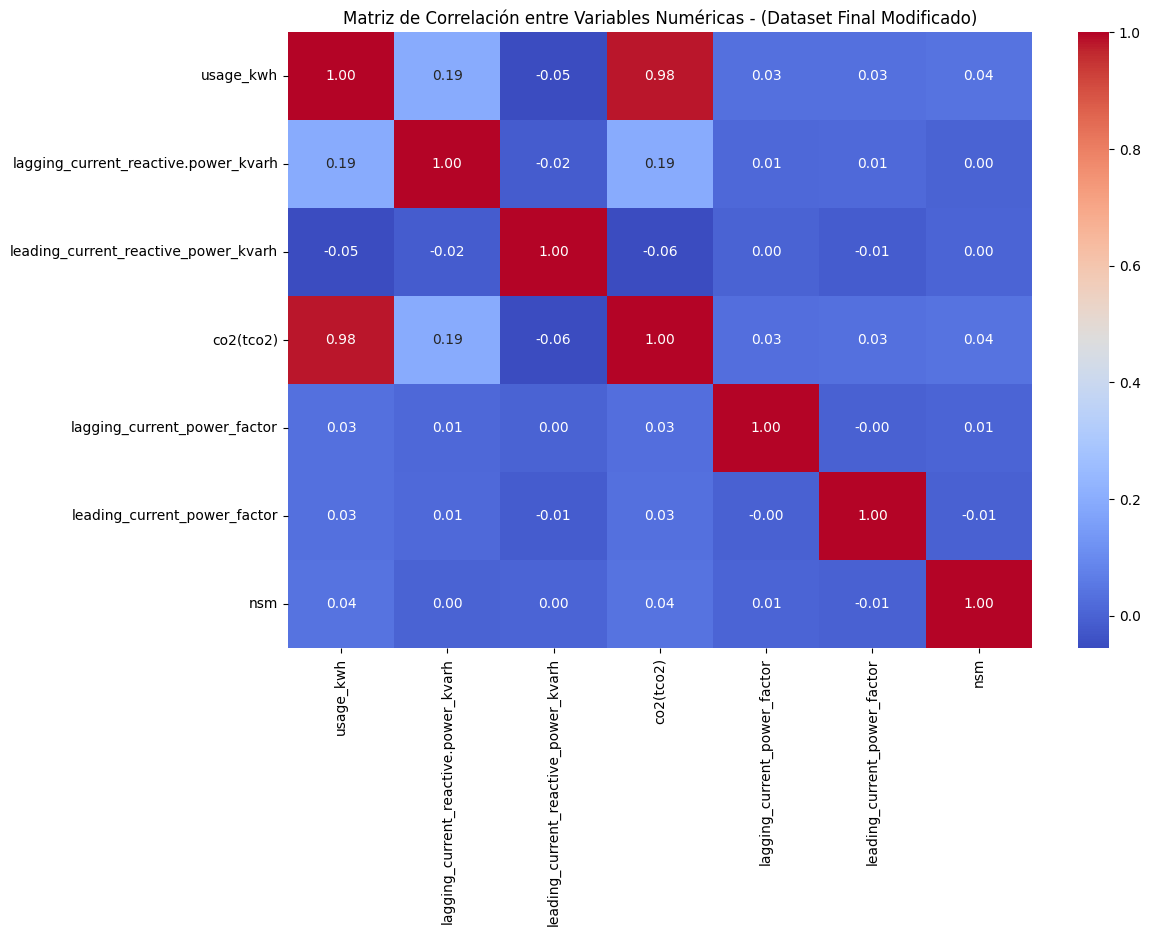

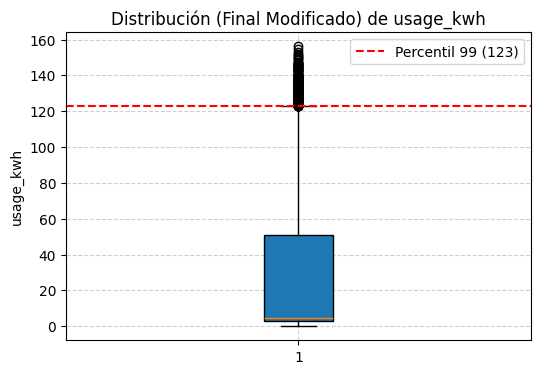


📊 ANÁLISIS PARA EL DATASET OBJETIVO (ORIGINAL)

Conteo de valores NaN por columna:
date                                    21216
usage_kwh                                   0
lagging_current_reactive.power_kvarh        0
leading_current_reactive_power_kvarh        0
co2(tco2)                                   0
lagging_current_power_factor                0
leading_current_power_factor                0
nsm                                         0
weekstatus                                  0
day_of_week                                 0
load_type                                   0
dtype: int64

Muestra aleatoria de 20 filas (df.sample(20)):


,date,usage_kwh,lagging_current_reactive.power_kvarh,leading_current_reactive_power_kvarh,co2(tco2),lagging_current_power_factor,leading_current_power_factor,nsm,weekstatus,day_of_week,load_type
18304,2018-10-07 16:15:00,89.14,35.10,0.00,0.04,93.05,100.00,58500,Weekday,Tuesday,Maximum_load
12506,2018-11-05 06:45:00,3.06,4.50,0.00,0.00,56.23,100.00,24300,Weekday,Friday,Light_load
27548,NaT,2.74,4.90,0.00,0.00,48.81,100.00,83700,Weekend,Sunday,Light_load
29328,2018-02-11 12:15:00,7.88,0.07,15.91,0.00,100.00,44.38,44100,Weekday,Friday,Medium_load
4506,NaT,3.13,3.56,0.00,0.00,66.03,100.00,81900,Weekday,Friday,Light_load
6321,2018-07-03 20:30:00,5.29,0.00,27.04,0.00,100.00,19.20,73800,Weekday,Wednesday,Medium_load
703,2018-08-01 08:00:00,6.73,5.11,0.00,0.00,79.64,100.00,28800,Weekday,Monday,Light_load
34827,NaT,3.31,0.00,13.93,0.00,100.00,23.12,68400,Weekend,Saturday,Light_load
4560,NaT,3.49,0.00,12.78,0.00,100.00,26.34,44100,Weekend,Saturday,Light_load
5769,2018-02-03 02:30:00,3.38,3.02,0.00,0.00,74.57,100.00,9000,Weekday,Friday,Light_load



Información del DataFrame (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  13824 non-null  datetime64[ns]
 1   usage_kwh                             35040 non-null  float64       
 2   lagging_current_reactive.power_kvarh  35040 non-null  float64       
 3   leading_current_reactive_power_kvarh  35040 non-null  float64       
 4   co2(tco2)                             35040 non-null  float64       
 5   lagging_current_power_factor          35040 non-null  float64       
 6   leading_current_power_factor          35040 non-null  float64       
 7   nsm                                   35040 non-null  int64         
 8   weekstatus                            35040 non-null  object        
 9   day_of_week                     

,date,usage_kwh,lagging_current_reactive.power_kvarh,leading_current_reactive_power_kvarh,co2(tco2),lagging_current_power_factor,leading_current_power_factor,nsm,weekstatus,day_of_week,load_type
32905,2018-09-12 18:30:00,3.31,0.0,9.25,0.0,100.0,33.69,66600,Weekend,Sunday,Light_load


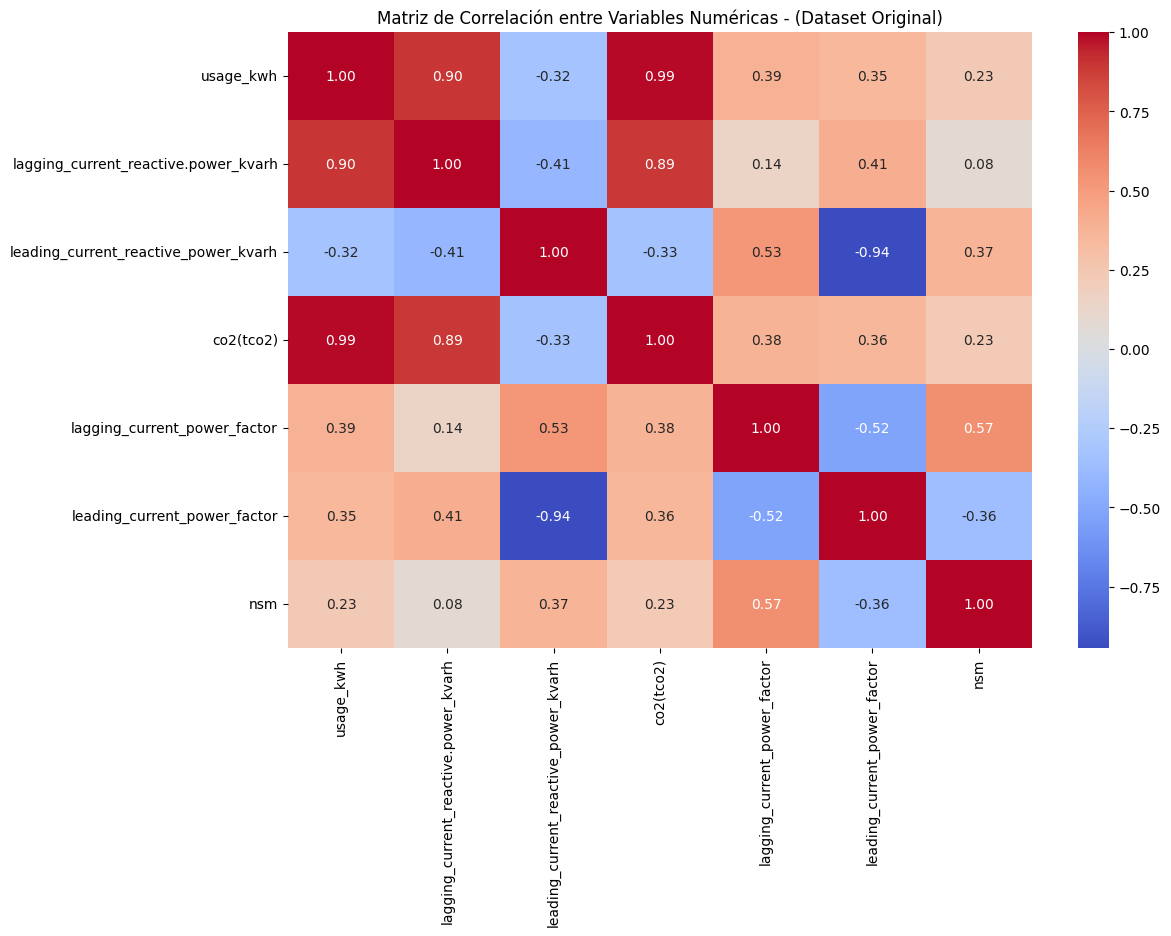

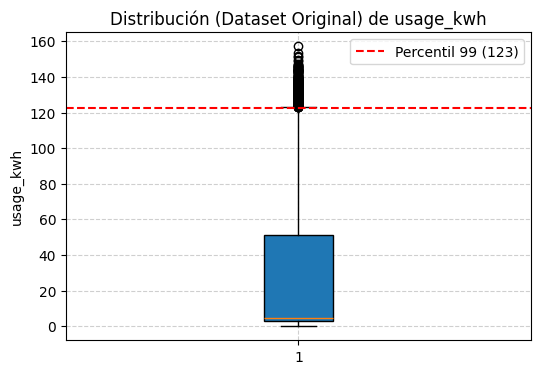


Comparación p99 -> Original: 122.708 | Modificado: 123.080

✅ Pipeline completado correctamente.



In [5]:
# ====================================
# MAIN - ANÁLISIS CON DOS DATASETS
# ====================================


def main(dataset_path_modificado: str, dataset_path_objetivo: str = None):
    """
    Ejecuta el flujo completo del análisis y limpieza para uno o dos datasets.
    
    Si se proporciona dataset_path_objetivo, también realiza las comparaciones
    y visualizaciones adicionales entre ambos (por ejemplo, matrices y boxplots).

    Parámetros
    ----------
    dataset_path_modificado : str
        Ruta al CSV del dataset modificado (limpiado o procesado).
    dataset_path_objetivo : str, opcional
        Ruta al CSV del dataset original (sin limpiar).

    Retorna
    -------
    dict con resultados principales.
    """

    print(f"\n📂 Cargando dataset MODIFICADO desde: {dataset_path_modificado}")
    df_mod = pd.read_csv(dataset_path_modificado)
    print(f"✅ Dataset modificado cargado con {df_mod.shape[0]} filas y {df_mod.shape[1]} columnas")

    df_obj = None
    if dataset_path_objetivo:
        print(f"\n📂 Cargando dataset OBJETIVO desde: {dataset_path_objetivo}")
        df_obj = pd.read_csv(dataset_path_objetivo)
        print(f"✅ Dataset objetivo cargado con {df_obj.shape[0]} filas y {df_obj.shape[1]} columnas")

    # --- 1) Limpieza del dataset modificado ---
    print("\n🧹 LIMPIEZA Y CORRECCIÓN DEL DATASET MODIFICADO")
    df_clean, row_32905 = clean_and_correct_formats(
        df_mod,
        numeric_cols=[
            "usage_kwh",
            "lagging_current_reactive.power_kvarh",
            "leading_current_reactive_power_kvarh",
            "co2(tco2)",
            "lagging_current_power_factor",
            "leading_current_power_factor",
            "nsm",
        ],
        text_cols=["weekstatus", "day_of_week", "load_type"],
        date_col="date",
        index_to_check=32905,
    )

    # --- 2) Univariado + filtrado de usage_kwh ---
    df_after_usage_cap = analyze_usage_kwh(df_clean, cap_value=157.0)

    # --- 3) lagging_current_reactive.power_kvarh ---
    analyze_lagging_reactive_kvarh(df_after_usage_cap)

    # --- 4) co2(tco2) ---
    df_final = analyze_co2_tco2(df_after_usage_cap, hard_cap=0.070)

    # --- 5) Matriz de correlación del dataset final ---
    corr_matrix_for(df_final, title_suffix="(Dataset Final Modificado)")

    # --- 6) Boxplot final del target ---
    p99_final_target = plot_box_p99_for(df_final, column=TARGET_COL, title_suffix="(Final Modificado)")

    # --- 7) Si hay dataset objetivo, hacer análisis paralelo ---
    if df_obj is not None:
        print("\n📊 ANÁLISIS PARA EL DATASET OBJETIVO (ORIGINAL)")

        # Limpieza del dataset objetivo (sin filtrar ni modificar valores)
        df_obj_clean, _ = clean_and_correct_formats(
            df_obj,
            numeric_cols=[
                "usage_kwh",
                "lagging_current_reactive.power_kvarh",
                "leading_current_reactive_power_kvarh",
                "co2(tco2)",
                "lagging_current_power_factor",
                "leading_current_power_factor",
                "nsm",
            ],
            text_cols=["weekstatus", "day_of_week", "load_type"],
            date_col="date",
            index_to_check=32905,
        )

        # Matriz de correlación para el dataset objetivo
        corr_matrix_for(df_obj_clean, title_suffix="(Dataset Original)")

        # Boxplot p99 para el target del dataset objetivo
        p99_obj = plot_box_p99_for(df_obj_clean, column=TARGET_COL, title_suffix="(Dataset Original)")

        print(f"\nComparación p99 -> Original: {p99_obj:.3f} | Modificado: {p99_final_target:.3f}")

    print("\n✅ Pipeline completado correctamente.\n")

    return {
        "df_clean": df_clean,
        "row_32905": row_32905,
        "df_after_usage_cap": df_after_usage_cap,
        "df_final": df_final,
        "p99_final_target": p99_final_target,
        "df_objetivo": df_obj if dataset_path_objetivo else None,
    }


# --- ejecución ---

if __name__ == "__main__":
    resultados = main(
        dataset_path_modificado="../../data/raw/steel_energy_modified.csv",
        dataset_path_objetivo="../../data/raw/steel_energy_original.csv"
    )

   
    # resultados["df_final"]
    # resultados["df_objetivo"]
    # resultados["p99_final_target"]
